In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from funciones import *

# modelos
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import uniform, randint, loguniform
from sklearn.metrics import accuracy_score

# Modelo red neuronal
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin


import warnings
warnings.filterwarnings('ignore')

# Modelamiento

## Correlaciones y Reducción de variables

In [2]:
# Cargamos los datos procesados
df_procesado = pd.read_csv("processed_data.csv")

In [3]:
#Vemos la correlaciones más altas
obtener_pares_correlacionados(df_procesado)

,Variable 1,Variable 2,Correlación
0,min15_cs,role_UTILITY,-0.927386


**Observaciones**

Encontramos correlaciones altas, pero no representan multicolinealidad, sino una relación evidente. Las variables por si solas son relevantes para la predicción.

## Spliteo de datos

In [4]:
X = df_procesado.drop(columns = ['win']) 
y = df_procesado['win']

# Spliteamos
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.30, random_state=42)

## Escalamiento de los datos

In [5]:
# Estandarizamos los datos para que todos tengan la misma medida
# Lista de columnas a excluir: item_, role_, rune_, champ_
exclude_cols = ['champion',
                'is_MMR_check',
                'role_JUNGLE',
                'role_UTILITY',
                'role_MIDDLE',
                'role_TOP',
                'first_blood',
                'first_rift_herald',
                'first_tower',
                'first_dragon',
                'is_flex']

X_train_scaled, X_test_scaled  = scaler(X_train, X_test, exclude_cols)

Se escalaron las siguientes columnas ['early_roam_kills', 'history_wr_champ', 'history_wr_global', 'min15_assists', 'min15_control_wards', 'min15_cs', 'min15_cs_diff', 'min15_deaths', 'min15_kills', 'min15_wards_killed', 'min15_wards_placed', 'min15_xp_diff', 'racha_previa', 'turret_plates', 'void_grubs']


## Regresión logistica

In [6]:
# Instanciamos el modelo, entrenamos y predecimos
model_log = LogisticRegression(random_state=42).fit(X_train_scaled, y_train)
y_pred_log = model_log.predict(X_test_scaled)

# Verificamos que el modelo no esté sobreajustado comparando x test con x train.
score_train = model_log.score(X_train_scaled, y_train)
score_test = model_log.score(X_test_scaled, y_test)

print(f"Rendimiento en Entrenamiento: {score_train:.2f}")
print(f"Rendimiento en Test (Realidad): {score_test:.2f}")

diferencia = score_train - score_test
print(f"Brecha (Gap): {diferencia:.2f}")

Rendimiento en Entrenamiento: 0.77
Rendimiento en Test (Realidad): 0.72
Brecha (Gap): 0.05


**Observaciones** 
- Podemos ver que a pesar de que el modelo tiene un gap de aprendizaje, en general aprende bien de los datos y logra predecir correctamente (0.72).

### Matríz de confusión de la regresión logística

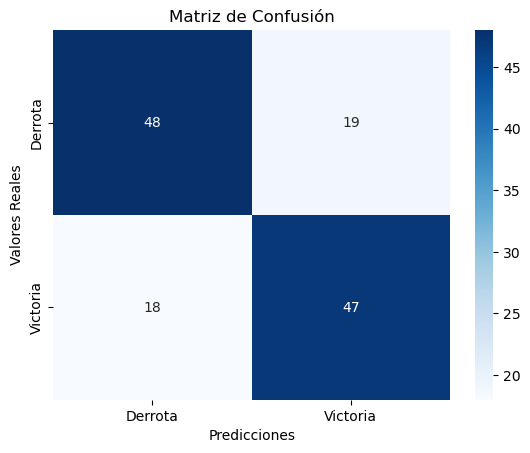


Reporte de Clasificación Regresión Logística:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72        67
           1       0.71      0.72      0.72        65

    accuracy                           0.72       132
   macro avg       0.72      0.72      0.72       132
weighted avg       0.72      0.72      0.72       132



In [7]:
# Crear un heatmap de la matriz de confusión para regresión logística
conf_matrix = confusion_matrix(y_test, y_pred_log)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Derrota', 'Victoria'], yticklabels=['Derrota', 'Victoria'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

print("\nReporte de Clasificación Regresión Logística:")
print(classification_report(y_test, y_pred_log))

**Observaciones** 
- A pesar de existen algunos falsos positivos y verdaderos negativos, en general tenemos un rendimiento del modelo decente, dando que su accuracy general de 0.72.
- El modelo detecta casi con el mismo f1 (f1 score = 0.72) score entre derrotas y victorias. No es notoriamente pesimista ni optimista.

### Curva ROC-AUC de la regresión logística

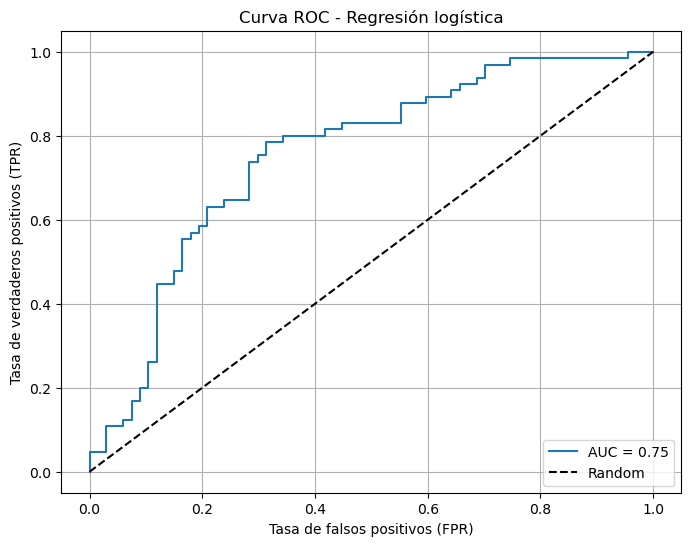

In [8]:
# Calculamos las probabilidades para Y
y_pred_prob = model_log.predict_proba(X_test_scaled)[:, 1]

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcular AUC
auc_score = roc_auc_score(y_test, y_pred_prob)

# Graficar
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - Regresión logística')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Observaciones** 
- El valor AUC es de 0.75 por lo que decentemente entre clases.

### Importancia de variables de Regresión Logística

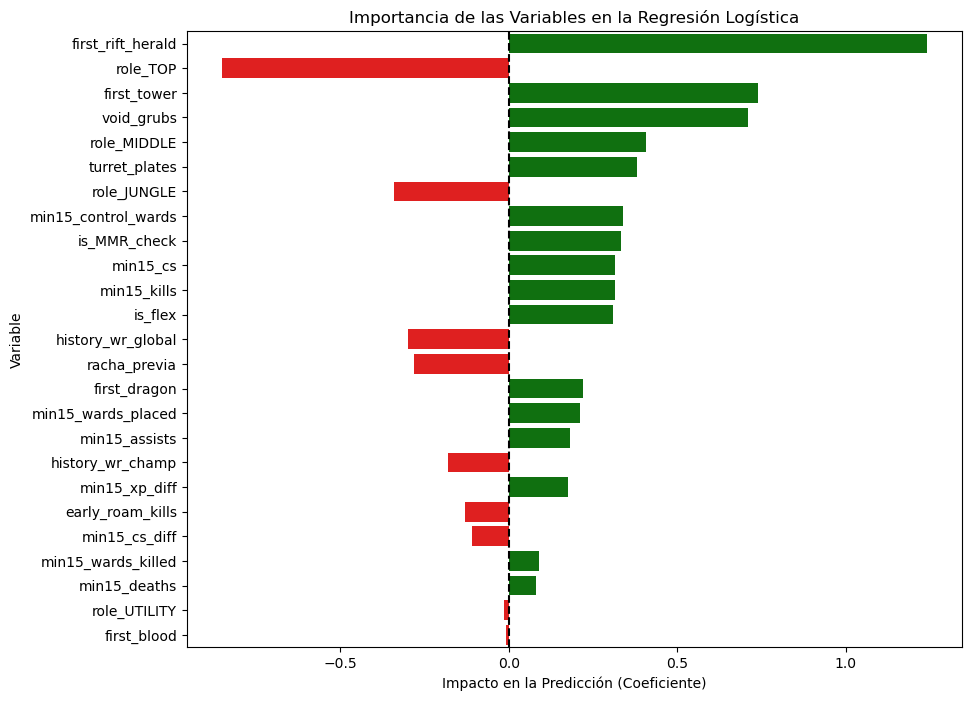

              Variable      Peso
0    first_rift_herald  1.240748
1             role_TOP -0.851218
2          first_tower  0.740555
3           void_grubs  0.709612
4          role_MIDDLE  0.406732
5        turret_plates  0.380461
6          role_JUNGLE -0.341866
7  min15_control_wards  0.337666
8         is_MMR_check  0.334526
9             min15_cs  0.314841


In [9]:
# Extraer coeficientes y nombres de columnas
# Asegúrate de usar las mismas columnas con las que entrenaste
feature_names = X_train_scaled.columns 
coefficients = model_log.coef_[0]

# Crear un DataFrame para ordenar
df_coefs = pd.DataFrame({
    'Variable': feature_names,
    'Peso': coefficients,
    'Absoluto': abs(coefficients) # Para ver impacto total (sea positivo o negativo)
})

# Ordenar por impacto absoluto (Las que más mueven la aguja)
df_coefs = df_coefs.sort_values(by='Absoluto', ascending=False,ignore_index = True)

# Visualizar
plt.figure(figsize=(10, 8))
# Usamos un mapa de color: Verde si ayuda a ganar (+), Rojo si ayuda a perder (-)
colors = ['green' if x > 0 else 'red' for x in df_coefs['Peso']]
sns.barplot(x='Peso', y='Variable', data=df_coefs, palette=colors)
plt.title('Importancia de las Variables en la Regresión Logística')
plt.xlabel('Impacto en la Predicción (Coeficiente)')
plt.axvline(x=0, color='black', linestyle='--') # Línea central
plt.show()

# Ver la tabla numérica
print(df_coefs[['Variable','Peso']].head(10))

**Observaciones** 

- Las variables con mayor capacidad predictora positiva son:

  - **first_rift_herald (1.24):** En el EDA detectamos que hacer el heraldo y tirar torre aumenta mucho la probabilidad de victoria. Este modelo lo confirma. Puede ser que, al ser uno de los 3 primeros objetivos para completar la misión monstruos neutrales para obtener las botas mejoradas (al igual que la primera torre), sea un punto fuerte para ganar. Además, por si mismo, genera oro global para el equipo.
    
  - **first_tower (0.74):** Al igual que el heraldo, tirar primera torre es parte de las misiones para obtener las botas mejoradas, solo que esta es una misión por si misma). Además, genera mucho oro global para el equipo.
    
  - **void_grubs (0.70):** Es parte de la mision de objetivos neurtrales, además de contribuir en la misión, ayuda a tirar torres más rapido al igual que el heraldo.
    
- Las variables con mayor capacidad predictora negativa son:

  - **role_TOP (-0.85) y role_JUNGLE (-0.34):** El simple hecho de juegar TOP y Jungla baja drásticamente la probabilidad de ganar en comparación a otros roles (MID aumenta las probabilidades).

## Support Vector Machine sin ajuste de hiperparámetros

In [10]:
# Definir el modelo base
svm_model = SVC(random_state=42, max_iter=100000).fit(X_train_scaled, y_train)

# Verificamos que el modelo no esté sobreajustado comparando x test con x train.
score_train = svm_model.score(X_train_scaled, y_train)
score_test = svm_model.score(X_test_scaled, y_test)

print(f"Rendimiento en Entrenamiento: {score_train:.2f}")
print(f"Rendimiento en Test (Realidad): {score_test:.2f}")

diferencia = score_train - score_test
print(f"Brecha (Gap): {diferencia:.2f}")

# Vemos el rendimiento del modelo
y_pred_svm = svm_model.predict(X_test_scaled)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_svm))

Rendimiento en Entrenamiento: 0.84
Rendimiento en Test (Realidad): 0.67
Brecha (Gap): 0.17

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.68      0.69      0.68        67
           1       0.67      0.66      0.67        65

    accuracy                           0.67       132
   macro avg       0.67      0.67      0.67       132
weighted avg       0.67      0.67      0.67       132



**Observación**

El gap entre test y train es grande (0.17), aún está memorizando más que aprendiendo. Ajustaremos hiperparámetros para controlar esto.

## Support Vector Machine con ajuste de hiperparámetros

In [11]:
# Instanciamos el modelo SVM
svm_model = SVC(random_state=42, max_iter=50000) # max_iter=50000 es para que no tarde infinito en converger

# Aplicamos random search para un acercamiento a los valores con mejor accuracy
param_random_svm = {
    # C: ¿Cuánto castigamos los errores? (Equivalente a aprender rápido o lento)
    # Buscamos desde 0.01 hasta 1000.
    'C': loguniform(0.01, 1000),          # Desde 0.01 hasta 1000 (Penalización)
    
    # Gamma: ¿Qué tan lejos llega la influencia de un punto? 
    # Buscamos desde 0.0001 hasta 1.
    'gamma': loguniform(0.0001, 1),       # Desde 0.0001 hasta 1 (Influencia)
    
    # Kernel: La forma geométrica de separar los datos.
    'kernel': ['linear', 'rbf', 'sigmoid'] # Tipos de kernel
}

# Randomizamos los hiperparámetros y guardamos los mejores.
random_search_svm = RandomizedSearchCV(
    svm_model, 
    param_distributions=param_random_svm, 
    n_iter=30,       # 20 intentos (SVM es lento, mantenemos 20 por seguridad)
    cv=5,            # CV bajo para velocidad en esta etapa
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Entrenamos el modelo
random_search_svm.fit(X_train_scaled, y_train)
print(f"El modelo tiene un accuracy (CV) esperado de: {random_search_svm.best_score_:.4f}")
print(f"Mejores parámetros: {random_search_svm.best_params_}")

# Verificamos que el modelo no esté sobreajustado comparando x test con x train.
best_svm_random = random_search_svm.best_estimator_
score_train = best_svm_random.score(X_train_scaled, y_train)
score_test = best_svm_random.score(X_test_scaled, y_test)

print(f"Rendimiento en Entrenamiento: {score_train:.2f}")
print(f"Rendimiento en Test (Realidad): {score_test:.2f}")

diferencia = score_train - score_test
print(f"Brecha (Gap): {diferencia:.2f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
El modelo tiene un accuracy (CV) esperado de: 0.7049
Mejores parámetros: {'C': np.float64(3.3818249433340135), 'gamma': np.float64(0.02159166403716299), 'kernel': 'sigmoid'}
Rendimiento en Entrenamiento: 0.73
Rendimiento en Test (Realidad): 0.70
Brecha (Gap): 0.03


In [12]:
# Rango de parámetros a probar
param_grid_svm = {
    'C': [40,58,80],
    'gamma': [0.0003, 0.0004,0.0005],
    'kernel': ['rbf'],
}

# Configurar búsqueda
grid_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenamos el modelo
grid_svm.fit(X_train_scaled, y_train)
print(f"El modelo tiene un accuracy (CV) esperado de: {grid_svm.best_score_:.4f}")
print(f"Mejores parámetros: {grid_svm.best_params_}")

# Verificamos que el modelo no esté sobreajustado comparando x test con x train.
best_svm_grid = grid_svm.best_estimator_
score_train = best_svm_grid.score(X_train_scaled, y_train)
score_test = best_svm_grid.score(X_test_scaled, y_test)

print(f"Rendimiento en Entrenamiento: {score_train:.2f}")
print(f"Rendimiento en Test (Realidad): {score_test:.2f}")

diferencia = score_train - score_test
print(f"Brecha (Gap): {diferencia:.2f}")

El modelo tiene un accuracy (CV) esperado de: 0.7049
Mejores parámetros: {'C': 40, 'gamma': 0.0005, 'kernel': 'rbf'}
Rendimiento en Entrenamiento: 0.76
Rendimiento en Test (Realidad): 0.70
Brecha (Gap): 0.07


**Observación**

El gap entre test y train se redujo considerablemente (0.07). Está aprendiendo mejor el modelo y prediciendo decente aún (0.70 accuracy). Podemos asegurar que el ajuste de hiperparámetros controló el overfiting, pero aún tiene algunos problemas para predecir correctamente (peor que la regresión)

### Matríz de confusión de SVM con ajuste de hiperparámetros

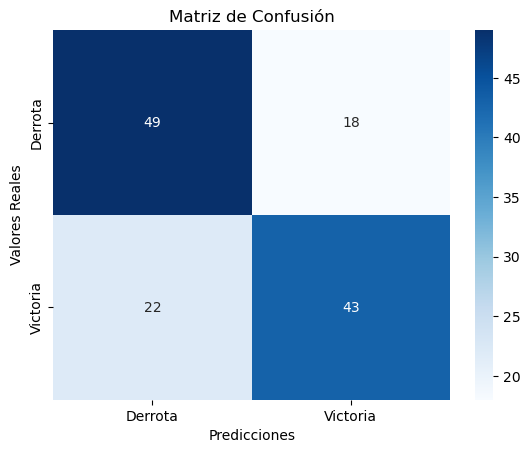


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        67
           1       0.70      0.66      0.68        65

    accuracy                           0.70       132
   macro avg       0.70      0.70      0.70       132
weighted avg       0.70      0.70      0.70       132



In [13]:
y_pred_svm = best_svm_grid.predict(X_test_scaled)

# Crear un heatmap de la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_svm)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Derrota', 'Victoria'], yticklabels=['Derrota', 'Victoria'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_svm))

**Observaciones** 
- Existen varios falsos positivos y falsos negativos (más que en regresíon logística), en general tenemos un rendimiento del modelo decente y un poco peor que la regresión logística (0.72 de accuracy)
- El modelo detecta un poco peor las victorias (f1 score = 0.68) que las derrotas (f1 score = 0.71). Es más sencillo para el modelo creer que voy a perder cuando voy ganando (22 falsos negativos) que ganar cuando voy perdiendo (18 falsos positivos).

### Curva ROC-AUC de SVM con ajuste de hiperparámetros

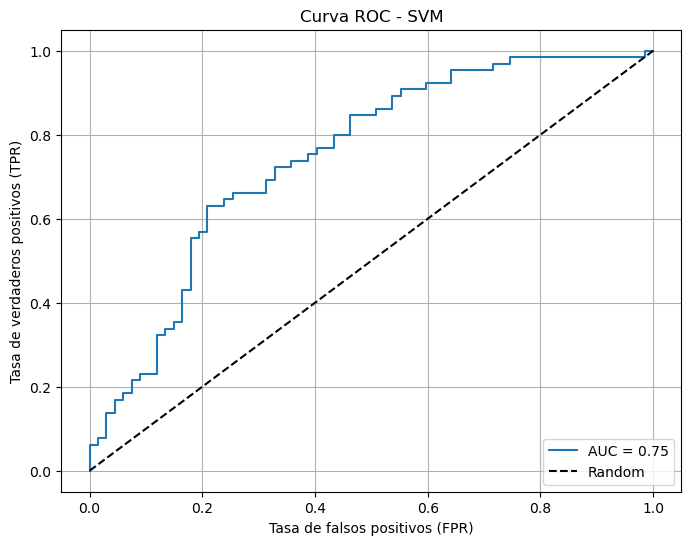

In [14]:
# Obtén los scores con decision_function
y_scores_svm = best_svm_grid.decision_function(X_test_scaled)

# Calcula ROC y AUC usando estos scores
fpr, tpr, thresholds = roc_curve(y_test, y_scores_svm)
auc = roc_auc_score(y_test, y_scores_svm)

# 4. Graficar
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Observaciones** 
- El valor AUC es de 0.75 por lo que el modelo detecta decentemente entre verdaderos positivos y falsos positivos. Un rendimiento similar a la regresión logistica, pero la regresión tiene un mejor rendimiento en general.

### Importancia de variables de SVM con ajuste de hiperparámetros

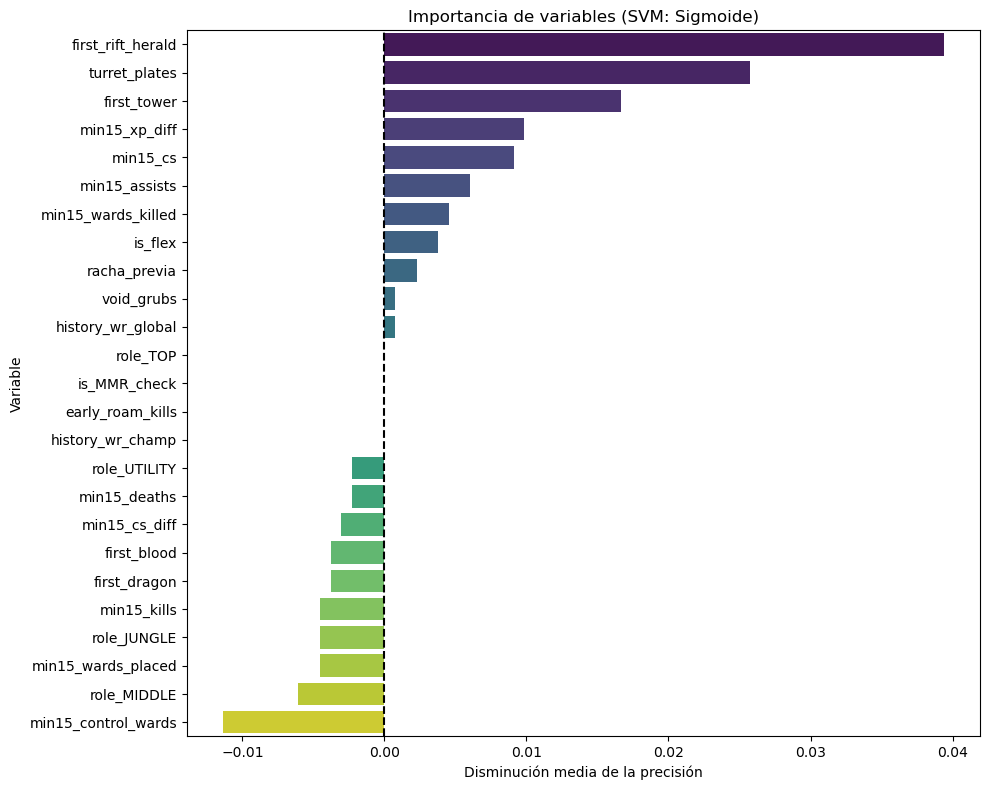

             Variable  Importancia
0   first_rift_herald     0.039394
1       turret_plates     0.025758
2         first_tower     0.016667
3       min15_xp_diff     0.009848
4            min15_cs     0.009091
5       min15_assists     0.006061
6  min15_wards_killed     0.004545
7             is_flex     0.003788
8        racha_previa     0.002273
9          void_grubs     0.000758


In [15]:
# OBTENER IMPORTANCIA MEDIANTE PERMUTACIÓN
results = permutation_importance(best_svm_grid, X_test_scaled, y_test, 
                                 n_repeats=10, 
                                 random_state=42, 
                                 n_jobs=-1)

# Extraer nombres y la media de la importancia
feature_names = X_train_scaled.columns
importances = results.importances_mean

# Crear DataFrame de importancias
df_importance = pd.DataFrame({
    'Variable': feature_names,
    'Importancia': importances
})

# Ordenar por importancia (de mayor a menor)
df_importance = df_importance.sort_values(by='Importancia', ascending=False, ignore_index=True)

# Visualizar
plt.figure(figsize=(10, 8))
# Usamos una paleta de un solo tono porque en no-lineales no hay "signo" simple
sns.barplot(x='Importancia', y='Variable', data=df_importance, palette='viridis')

plt.title('Importancia de variables (SVM: Sigmoide)')
plt.xlabel('Disminución media de la precisión')
plt.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

print(df_importance.head(10))

**Observaciones** 

- Las variables que inciden más en accuracy al ser "aleatorizadas" son:

  - **first_rift_herald (3.9%):** Al igual que en regresión este modelo confirma nuevamente que el heraldo es el principal predictor.
    
  - **turret_plates (2.5%):** Según SVM el accuracy varía un 2.5% al aleatorizar las placas de torres obtenidas. A diferencia de la regresión que tomó en consideración el Rol, SVM usó las placas de torre, tener más o menos placas hace que el modelo logre detectar derrotas o victorias. Sin embargo el rendimiento del modelo sigue siendo peor en predicción.
 
  - **first_tower (1.6%):** Al igual que en regresión, SVM detecta como una de las variables predictoras tirar primera torre.
 
  - **min15_xp_diff (0.9%):** La diferencia de XP logra posicionarse un poco más lejos, pero resulta una relevancia similar que al de la primera torre

## Decision Tree sin ajuste de hiperparámetros

In [16]:
# Instanciamos el modelo y entrenamos
dt_model = DecisionTreeClassifier(random_state=42).fit(X_train_scaled, y_train)

# Verificamos que el modelo no esté sobreajustado comparando x test con x train.
score_train = dt_model.score(X_train_scaled, y_train)
score_test = dt_model.score(X_test_scaled, y_test)

print(f"Rendimiento en Entrenamiento: {score_train:.2f}")
print(f"Rendimiento en Test (Realidad): {score_test:.2f}")

diferencia = score_train - score_test
print(f"Brecha (Gap): {diferencia:.2f}")

# Vemos el rendimiento del modelo
y_pred_dt = dt_model.predict(X_test_scaled)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_dt))

Rendimiento en Entrenamiento: 1.00
Rendimiento en Test (Realidad): 0.66
Brecha (Gap): 0.34

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.65      0.72      0.68        67
           1       0.67      0.60      0.63        65

    accuracy                           0.66       132
   macro avg       0.66      0.66      0.66       132
weighted avg       0.66      0.66      0.66       132



**Observación**

El gap entre test y train es gigantezco (0.34), está memorizando demasiado, mucho más que aprendiendo. Ajustaremos hiperparámetros para controlar esto.
Claramente no logra identificar bien las victorias

## Decision tree con ajuste de hiperparámetros

In [17]:
dt_model = DecisionTreeClassifier(random_state=42)

# Primero aplicamos random search para una acercamiento a los valores con mejor accuracy
param_random_dt = {
    'max_depth': randint(5, 15),          # profundidad máxima de cada árbol
    'min_samples_split': randint(10, 100),    # mínimo para dividir nodo
    'min_samples_leaf': randint(10, 40),      # mínimo por hoja
}

# Randomizamos los hiperparámetros y guardamos los mejores.
random_search_dt = RandomizedSearchCV(
    dt_model, 
    param_distributions=param_random_dt, 
    n_iter=50,       # Probamos 50 combinaciones al azar
    cv=5,            # CV bajo para velocidad en esta etapa
    scoring='accuracy', 
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Entrenamos el modelo
random_search_dt.fit(X_train_scaled, y_train)
print(f"El modelo tiene un accuracy (CV) esperado de: {random_search_dt.best_score_:.4f}")
print(f"Mejores parámetros: {random_search_dt.best_params_}")

# Verificamos que el modelo no esté sobreajustado comparando x test con x train.
best_dt_random = random_search_dt.best_estimator_
score_train = best_dt_random.score(X_train_scaled, y_train)
score_test = best_dt_random.score(X_test_scaled, y_test)

print(f"Rendimiento en Entrenamiento: {score_train:.2f}")
print(f"Rendimiento en Test (Realidad): {score_test:.2f}")

diferencia = score_train - score_test
print(f"Brecha (Gap): {diferencia:.2f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
El modelo tiene un accuracy (CV) esperado de: 0.6721
Mejores parámetros: {'max_depth': 11, 'min_samples_leaf': 35, 'min_samples_split': 92}
Rendimiento en Entrenamiento: 0.72
Rendimiento en Test (Realidad): 0.63
Brecha (Gap): 0.09


In [18]:
# Definir la grilla de hiperparámetros
param_grid_dt = {
    'max_depth': [10, 11, 15],             # profundidad máxima
    'min_samples_leaf': [10,15,35],        # mínimo por hoja
    'min_samples_split': [10,50,92],       # mínimo para dividir nodo

}

# GridSearch con validación cruzada
grid_dt = GridSearchCV(dt_model, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenamos el modelo
grid_dt.fit(X_train_scaled, y_train)
print(f"Mejores parámetros grilla: {grid_dt.best_params_}")
print(f"El modelo tiene un accuracy (CV) esperado de: {grid_dt.best_score_:.4f}")

# Verificamos que el modelo no esté sobreajustado comparando x test con x train.
best_dt_grid = grid_dt.best_estimator_
score_train = best_dt_grid.score(X_train_scaled, y_train)
score_test = best_dt_grid.score(X_test_scaled, y_test)

print(f"Rendimiento en Entrenamiento: {score_train:.2f}")
print(f"Rendimiento en Test (Realidad): {score_test:.2f}")

diferencia = score_train - score_test
print(f"Brecha (Gap): {diferencia:.2f}")

Mejores parámetros grilla: {'max_depth': 10, 'min_samples_leaf': 35, 'min_samples_split': 92}
El modelo tiene un accuracy (CV) esperado de: 0.6721
Rendimiento en Entrenamiento: 0.72
Rendimiento en Test (Realidad): 0.63
Brecha (Gap): 0.09


**Observación**

El gap entre test y train se redujo considerablemente (0.09), está reduciendo el overfiting pero prediciendo deficiente (0.63 accuracy). Podemos asegurar que el ajuste de hiperparámetros controló el overfiting pero no una mejor predicción.

### Matríz de confusión de Decision Tree

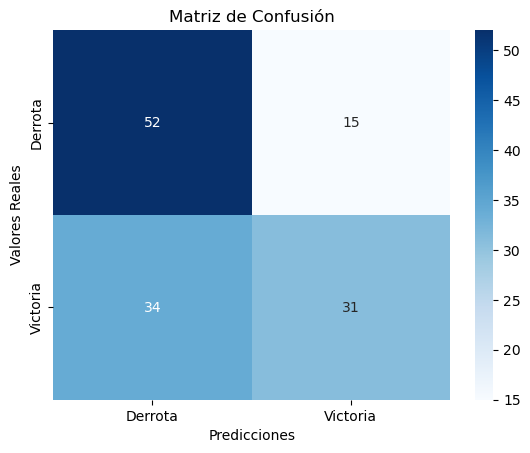


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.60      0.78      0.68        67
           1       0.67      0.48      0.56        65

    accuracy                           0.63       132
   macro avg       0.64      0.63      0.62       132
weighted avg       0.64      0.63      0.62       132



In [19]:
y_pred_dt = best_dt_grid.predict(X_test_scaled)

# Crear un heatmap de la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_dt)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Derrota', 'Victoria'], yticklabels=['Derrota', 'Victoria'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_dt))

**Observaciones** 
- Existen muchos falsos negativos, más que en cualquier modelo anterior. En general tenemos un rendimiento deficiente del modelo, bastante peor que la regresión logística (0.72 de accuracy)
- El modelo detecta mucho peor las victorias (f1 score = 0.56) que las derrotas (f1 score = 0.68). Es mucho más sencillo para el modelo creer que voy a perder cuando voy ganando (34 falsos negativos) que ganar cuando voy perdiendo (15 falsos positivos).

### Curva ROC-AUC de Decision tree

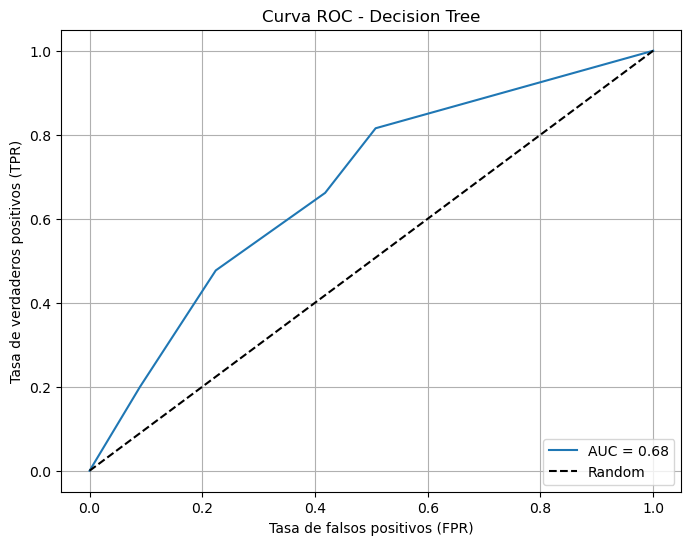

In [20]:
# Probabilidad de la clase positiva (1, por ejemplo "victoria")
y_probs_dt = best_dt_grid.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs_dt)
auc = roc_auc_score(y_test, y_probs_dt)

# 4. Graficar
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - Decision Tree')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Observaciones** 
- El valor AUC es de 0.68 por lo que el modelo detecta no tan bien entre verdaderos positivos y falsos positivos.

### Importancia de variables de Decision tree con ajuste de hiperparámetros

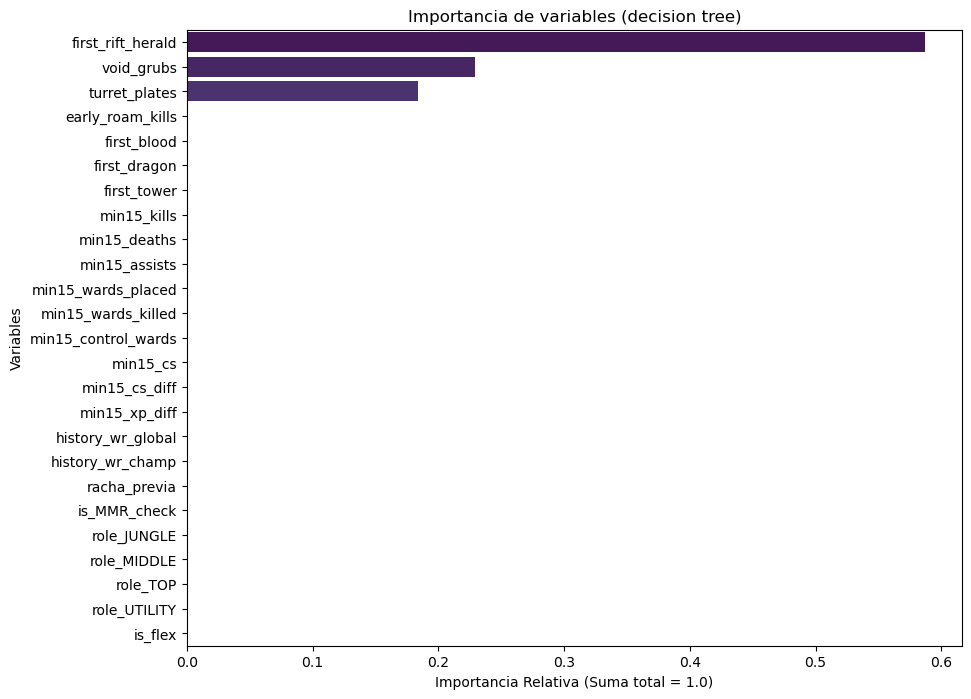

           Variables  Importancia
0  first_rift_herald     0.587071
1         void_grubs     0.229179
2      turret_plates     0.183751


In [21]:
importances = best_dt_grid.feature_importances_
feature_names = X_train_scaled.columns

# Crear DataFrame para importancias
df_tree_imp = pd.DataFrame({
    'Variables': feature_names,
    'Importancia': importances
})

# Ordenar de mayor a menor
df_tree_imp = df_tree_imp.sort_values(by='Importancia', ascending=False, ignore_index=True)

# Visualizar
plt.figure(figsize=(10, 8))
sns.barplot(x='Importancia', y='Variables', data=df_tree_imp, palette='viridis')

plt.title('Importancia de variables (decision tree)')
plt.xlabel('Importancia Relativa (Suma total = 1.0)')
plt.show()

# 5. Ver tabla
print(df_tree_imp.head(3))

**Observaciones** 

Se ve algo muy extraño, el arbol no está logrando aprender las sutilezas de los datos para lograr predecir, solo esta reduciendo todo a 3 variables, lo que lo underfitea enormemente, está generalizando demasiado y lo hace perder mucho accuracy. Esto puede deberse a la baja cantidad de registros, por lo que no puede aprender bien de los detalles.

Aún asi, logra detectar un gran predictor:

  - **first_rift_herald (0.58):** Al igual que en regresión este modelo confirma nuevamente que el heraldo es el principal predictor. Es la variables que logró detectar más entre derrotas y victorias.

A pesar de lo anterior, este modelo es malo respecto a los otros, por lo que veremos si mejora en random forest (varios árboles)
 
 


## Random Forest sin ajuste de hiperparámetros

In [22]:
# Instanciamos el modelo Random forest y fiteamos
model_rf = RandomForestClassifier(random_state=42).fit(X_train_scaled, y_train)

score_train = model_rf.score(X_train_scaled, y_train)
score_test = model_rf.score(X_test_scaled, y_test)

print(f"Rendimiento en Entrenamiento: {score_train:.2f}")
print(f"Rendimiento en Test (Realidad): {score_test:.2f}")

diferencia = score_train - score_test
print(f"Brecha (Gap): {diferencia:.2f}")

Rendimiento en Entrenamiento: 1.00
Rendimiento en Test (Realidad): 0.69
Brecha (Gap): 0.31


**Observación**

El gap entre test y train es muy grande (0.31), está memorizando más que aprendiendo. Ajustaremos hiperparámetros para controlar esto.

## Random Forest con ajuste de hiperparámetros

In [23]:
# Primero aplicamos random search para una acercamiento a los valores con mejor accuracy
param_random_rf = {
    'n_estimators': randint(100, 300),      # cantidad de árboles
    'max_depth': randint(5, 15),          # profundidad máxima de cada árbol
    'min_samples_split': randint(20, 100),    # mínimo para dividir nodo
    'min_samples_leaf': randint(10, 40),      # mínimo por hoja
}

# Randomizamos los hiperparámetros y guardamos los mejores.
random_search_rf = RandomizedSearchCV(
    model_rf, 
    param_distributions=param_random_rf, 
    n_iter=50,       # Probamos 50 combinaciones al azar
    cv=3,            # CV bajo para velocidad en esta etapa
    scoring='accuracy', 
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Entrenamos el modelo
random_search_rf.fit(X_train_scaled, y_train)
print(f"El modelo tiene un accuracy (CV) esperado de: {random_search_rf.best_score_:.4f}")
print(f"Mejores parámetros: {random_search_rf.best_params_}")

# Verificamos que el modelo no esté sobreajustado comparando x test con x train.
best_rf = random_search_rf.best_estimator_
score_train = best_rf.score(X_train_scaled, y_train)
score_test = best_rf.score(X_test_scaled, y_test)

print(f"Rendimiento en Entrenamiento: {score_train:.2f}")
print(f"Rendimiento en Test (Realidad): {score_test:.2f}")

diferencia = score_train - score_test
print(f"Brecha (Gap): {diferencia:.2f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
El modelo tiene un accuracy (CV) esperado de: 0.7182
Mejores parámetros: {'max_depth': 6, 'min_samples_leaf': 35, 'min_samples_split': 28, 'n_estimators': 189}
Rendimiento en Entrenamiento: 0.75
Rendimiento en Test (Realidad): 0.71
Brecha (Gap): 0.04


In [24]:
# Definimos una Grid basada en lo que encontró el Random
param_grid = {
    'max_depth': [5, 6, 7],             
    'min_samples_leaf': [34,35,36],       
    'min_samples_split': [26,28,30],      
    'n_estimators': [187, 189, 191],      
}

# Configurar GridSearchCV
grid_rf = GridSearchCV(
    model_rf,
    param_grid=param_grid,
    cv=5,            
    scoring='accuracy',
    n_jobs=-1
)

# Entrenamos el modelo
grid_rf.fit(X_train_scaled, y_train)
print(f"Mejores parámetros grilla: {grid_rf.best_params_}")
print(f"El modelo tiene un accuracy (CV) esperado de: {grid_rf.best_score_:.4f}")

# Verificamos que el modelo no esté sobreajustado comparando x test con x train.
best_rf = grid_rf.best_estimator_
score_train = best_rf.score(X_train_scaled, y_train)
score_test = best_rf.score(X_test_scaled, y_test)

print(f"Rendimiento en Entrenamiento: {score_train:.2f}")
print(f"Rendimiento en Test (Realidad): {score_test:.2f}")

diferencia = score_train - score_test
print(f"Brecha (Gap): {diferencia:.2f}")

Mejores parámetros grilla: {'max_depth': 5, 'min_samples_leaf': 34, 'min_samples_split': 26, 'n_estimators': 187}
El modelo tiene un accuracy (CV) esperado de: 0.7115
Rendimiento en Entrenamiento: 0.75
Rendimiento en Test (Realidad): 0.71
Brecha (Gap): 0.04


**Observación**

El gap entre test y train se redujo considerablemente (0,4), está aprendiendo el modelo y prediciendo decentemente (0.71 accuracy). Podemos asegurar que el ajuste de hiperparámetros controló el overfiting y mejoró el aprendizaje.

### Matríz de confusión de Random Forest con ajuste de hiperparámetros

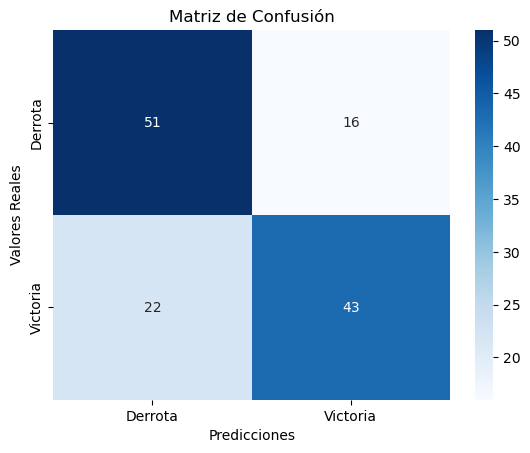


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73        67
           1       0.73      0.66      0.69        65

    accuracy                           0.71       132
   macro avg       0.71      0.71      0.71       132
weighted avg       0.71      0.71      0.71       132



In [25]:
y_pred_rf = best_rf.predict(X_test_scaled)

# Crear un heatmap de la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Derrota', 'Victoria'], yticklabels=['Derrota', 'Victoria'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf))

**Observaciones** 
- Existen muchos varios falsos negativos(22). En general tenemos un rendimiento aceptable del modelo (0.71 de accuracy), bastante similar a la regresión logística (0.72 accuracy)
- El modelo detecta mucho peor las victorias (f1 score = 0.69) que las derrotas (f1 score = 0.73). Al igual que la mayoria del resto de modelos, es mucho más sencillo para el modelo creer que voy a perder cuando voy ganando (22 falsos negativos) que ganar cuando voy perdiendo (16 falsos positivos).

### Curva ROC-AUC de Random Forest con ajuste de hiperparámetros

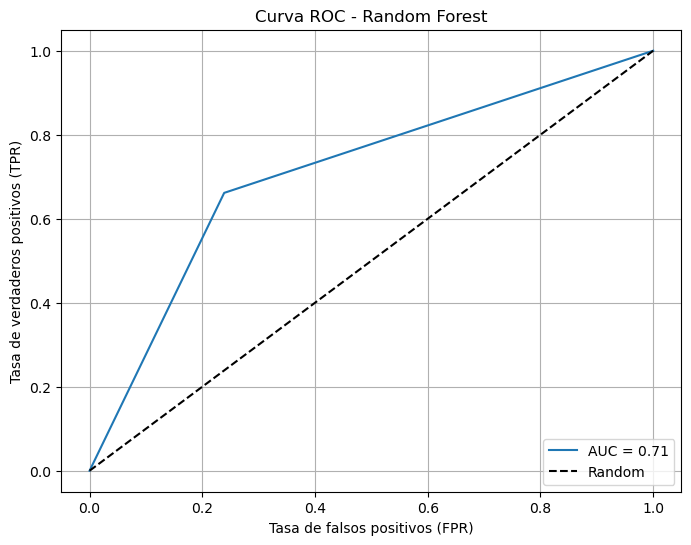

In [26]:
# Probabilidad de la clase positiva (1, por ejemplo "victoria")
y_probs_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
auc = roc_auc_score(y_test, y_pred_rf)

# Graficar
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Observaciones** 
- El valor AUC es de 0.71 por lo que el modelo detecta decentemente entre verdaderos positivos y falsos positivos, pero peor que la regresión logística (auc = 0.75).

### Importancia de variables de Random Forest con ajuste de hiperparámetros

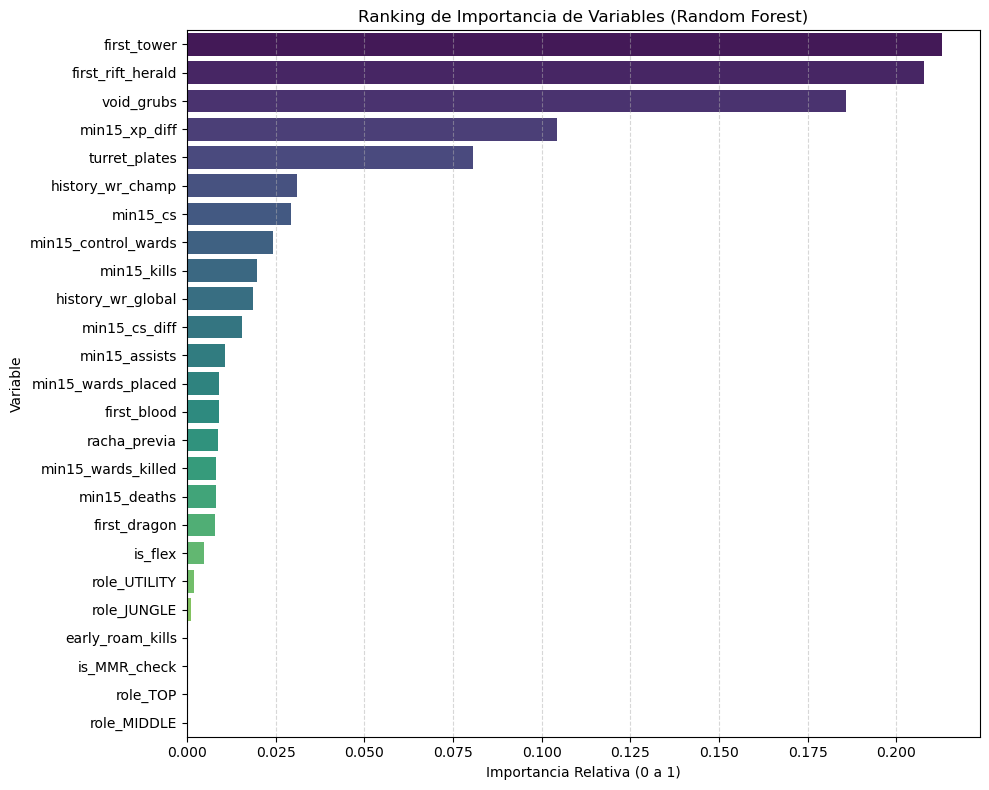

              Variable  Importancia
0          first_tower     0.212930
1    first_rift_herald     0.207658
2           void_grubs     0.185839
3        min15_xp_diff     0.104255
4        turret_plates     0.080680
5     history_wr_champ     0.031109
6             min15_cs     0.029467
7  min15_control_wards     0.024225
8          min15_kills     0.019630
9    history_wr_global     0.018612


In [27]:
# Obtener la importancia media
importances = best_rf.feature_importances_
feature_names = X_train_scaled.columns

# Crear DataFrame de las importancias
df_rf_imp = pd.DataFrame({
    'Variable': feature_names,
    'Importancia': importances
})

# Ordenar de mayor a menor
df_rf_imp = df_rf_imp.sort_values(by='Importancia', ascending=False, ignore_index=True)

# Visualizar (Versión Limpia)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importancia', y='Variable', data=df_rf_imp, palette='viridis')
plt.title('Ranking de Importancia de Variables (Random Forest)')
plt.xlabel('Importancia Relativa (0 a 1)')
plt.grid(axis='x', linestyle='--', alpha=0.5) # Rejilla suave para ayudar a leer
plt.tight_layout()
plt.show()

print(df_rf_imp.head(10))

**Observaciones** 

A diferencia del Arbol de Desición, el Random Forest logró aprender más sutilezas.

- Las variables que inciden más en la prediccón de victoria o derrota en cada registro son:

  - **first_tower(0.21):** Al diferencia que en otros modelos, el RF considera que la primera torre es más relevante que el heraldo.
 
  - **first_rift_herald (0.20):** Como segundo predictor, asesinar el Heraldo es, al igual que en regresión, una de las variables predictoras. Sin embargo, pierde un poco importancia. Esto podría deberse a posibles fallos con el heraldo, debido a que puedes asesinarlo y no generar valor, pero la primera torre siempre generará valor al equipo.
    
  - **void_grubs (0.18):** Según RF asesinar voids contribuye más a la predicción más que el rol (conclusión similar a SVM). A diferencia de la regresión que tomó en consideración el Rol (en RF casi no inciden realmente).
 
  - **min15_xp_diff (0.10):** Según RF y regresión, la diferencia de XP contribuye un poco a la predicción. No más que la primera torre o heraldo, pero  si mucho más que el KDA, por lo que concentrarse en obtener XP más que asesinatos puede ser un factor a considerar.
 
 

## Red neuronal

In [28]:
# Crear modelo
model_mlp = Sequential([
    Dense(32, activation='relu', kernel_initializer=HeNormal(),
          use_bias=True,
          input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.1),

    Dense(16, activation='relu', kernel_initializer=HeNormal(),
          use_bias=True),
    Dropout(0.1),

    Dense(8, activation='relu', kernel_initializer=HeNormal(),
          use_bias=True),
    
    Dense(1, activation='sigmoid')  # salida binaria
])

model_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,505 (5.88 KB)

 Trainable params: 1,505 (5.88 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compilar la red neuroanl
model_mlp.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Early stop para parar si no mejora la red neuronal
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,         # Espera 10 épocas antes de detenerse
    restore_best_weights=True # Vuelve al mejor momento, no al último
)

# Entrenar
history = model_mlp.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=200,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5180 - loss: 0.7326 - val_accuracy: 0.4924 - val_loss: 0.7345
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5180 - loss: 0.7155 - val_accuracy: 0.4924 - val_loss: 0.7196
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5607 - loss: 0.6844 - val_accuracy: 0.5303 - val_loss: 0.7118
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5541 - loss: 0.6813 - val_accuracy: 0.5682 - val_loss: 0.7051
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5705 - loss: 0.6548 - val_accuracy: 0.5758 - val_loss: 0.6972
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6393 - loss: 0.6432 - val_accuracy: 0.5833 - val_loss: 0.6912
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5934 - loss: 0.6513 - val_accuracy: 0.5985 - val_loss: 0.6885
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5803 - loss: 0.6602 - val_accuracy: 0.6136 -

Rendimiento en Entrenamiento: 0.72
Rendimiento en Test (Realidad): 0.62
Brecha (Gap): 0.10


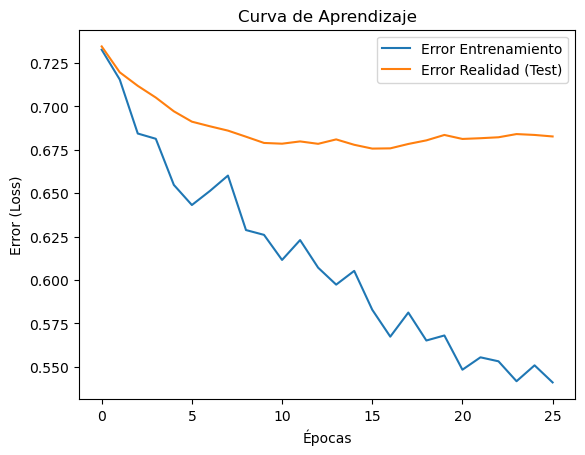

In [30]:
# Revisamos overfiting
loss_train, acc_train = model_mlp.evaluate(X_train_scaled, y_train, verbose=0)
loss_test, acc_test = model_mlp.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Rendimiento en Entrenamiento: {acc_train:.2f}")
print(f"Rendimiento en Test (Realidad): {acc_test:.2f}")
print(f"Brecha (Gap): {acc_train - acc_test:.2f}")

# 5. VISUALIZAR LA CURVA (Para ver cuándo empezó a overfitear)
plt.plot(history.history['loss'], label='Error Entrenamiento')
plt.plot(history.history['val_loss'], label='Error Realidad (Test)')
plt.title('Curva de Aprendizaje')
plt.ylabel('Error (Loss)')
plt.xlabel('Épocas')
plt.legend()
plt.show()

**Observación**

El gap entre test y train es grande (0.12). Pero lo que más preocupación da es el estancamiento del error en el test. Intentó aprender pero seguramente con tan pocos datos se estancó y no logró obtener más patrones complejos.

### Matríz de confusión de Red neuronal

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


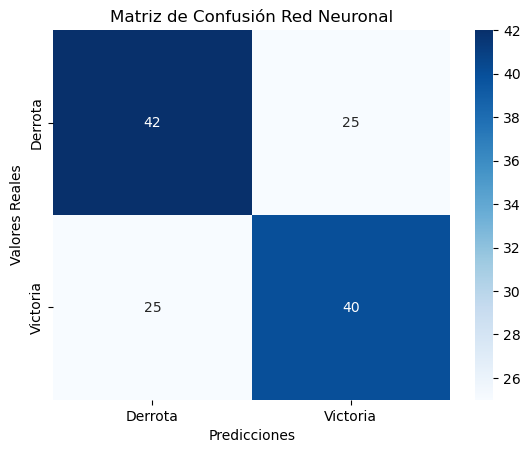


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63        67
           1       0.62      0.62      0.62        65

    accuracy                           0.62       132
   macro avg       0.62      0.62      0.62       132
weighted avg       0.62      0.62      0.62       132



In [31]:
# Predicción
y_pred_prob = model_mlp.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)  # convertir a 0/1

# Crear un heatmap de la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Derrota', 'Victoria'], yticklabels=['Derrota', 'Victoria'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión Red Neuronal')
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

**Observaciones** 
- Existen muchos varios falsos negativos(25). En general tenemos un rendimiento mediocre del modelo (0.62 de accuracy), peor que el árbol de decisión.

### Curva Roc-AUC con Red Neuronal multicapa

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


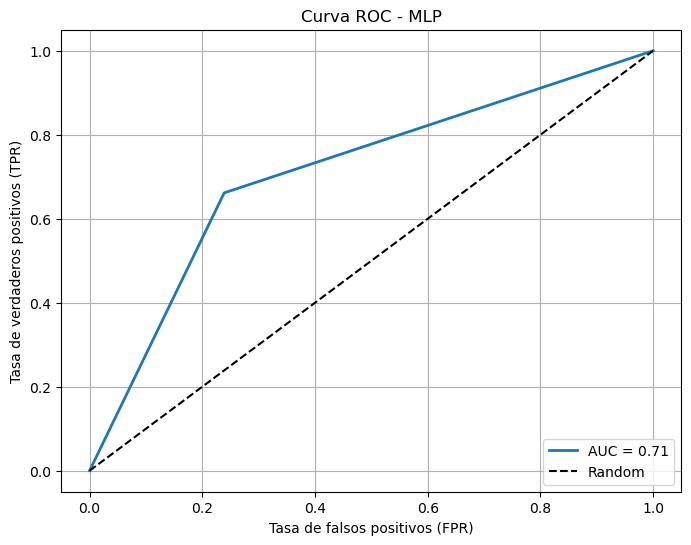

In [32]:
# Probabilidad de la clase positiva (1, por ejemplo "victoria")
y_probs_mlp = model_mlp.predict(X_test_scaled).ravel()  # ravel() para dejarlo 1D

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', linewidth=2)
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - MLP')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Observaciones** 
- El valor AUC es de 0.71 por lo que el modelo detecta decentemente entre verdaderos positivos y falsos positivos, pero peor que la regresión logística (auc = 0.75). Aún asi, las probabilidades que asigna son bajas y al pasar por un umbral mínimo del 50% de probabilidad de acertar, baja el accuracy a 0.60.

### Importancia de variables de Red Neuronal multicapa

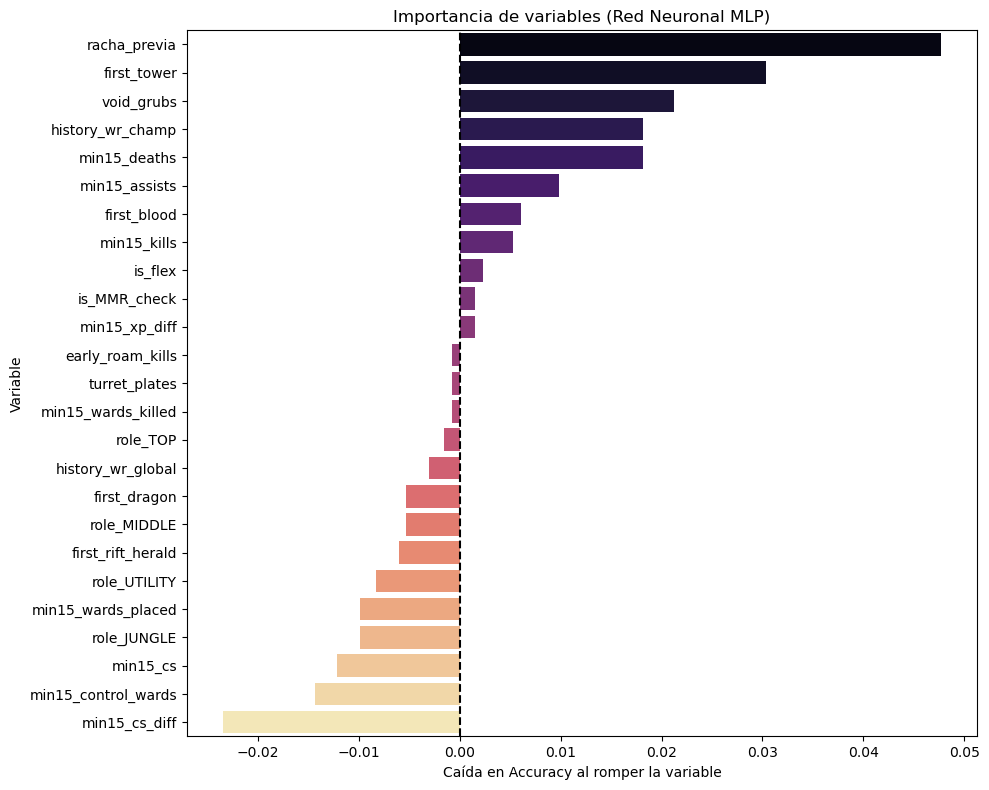

            Variable  Importancia
18      racha_previa     0.047727
3        first_tower     0.030303
6         void_grubs     0.021212
17  history_wr_champ     0.018182
8       min15_deaths     0.018182
9      min15_assists     0.009848
2        first_blood     0.006061
7        min15_kills     0.005303
24           is_flex     0.002273
19      is_MMR_check     0.001515


In [33]:
# Creamos una clase que "disfraza" a Keras como si fuera un SVM de Sklearn
class KerasSklearnWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y):
        return self # No hacemos nada, ya está entrenado
        
    def predict(self, X):
        # Convertimos la probabilidad de Keras a 0 o 1
        return (self.model.predict(X, verbose=0) > 0.5).astype("int32")
        
    def score(self, X, y):
        # Calculamos accuracy
        return accuracy_score(y, self.predict(X))

# Envolvemos el modelo entrenado
wrapped_model = KerasSklearnWrapper(model_mlp)

results = permutation_importance(wrapped_model, X_test_scaled, y_test, 
                                 n_repeats=10, 
                                 random_state=42, 
                                 n_jobs=1) # n_jobs=1 evita conflictos con TensorFlow

# Procesar resultados
feature_names = X_train_scaled.columns
importances = results.importances_mean

# Crea un df con las importancias
df_importance_mlp = pd.DataFrame({
    'Variable': feature_names,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

# Visualizar
plt.figure(figsize=(10, 8))
sns.barplot(x='Importancia', y='Variable', data=df_importance_mlp, palette='magma') # Magma para diferenciar
plt.title('Importancia de variables (Red Neuronal MLP)')
plt.xlabel('Caída en Accuracy al romper la variable')
plt.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

print(df_importance_mlp.head(10))

**Observación**

Las variables más relevantes se asemejan a los errores de la regresión, "racha previa contribuye más a saber si gano o pierdo". Esto no me pareceren a primera vista algo lógico, quizas  la red neuronal con tan pocos datos llegó a una aprendizaje muy genérico y no logró aprender más relaciones complejas, quedándose estancado solo si estoy en racha de derrotas o victorias. Aún asi, si lo comparo con el resto de modelos, se asemeja a en algunas variables como la primera torre y los voids grabs. La red está confundida, pero aún asi logra detectar patrones relevantes.

El auc, la baja precisión, los pocos datos y el estancamiento en el error de test, son indicadores de que, para este set de datos, una red neuornal multicapa es el peor modelo aplicable.

## XGB sin ajuste de hiperparámetros

In [34]:
# Instanciamos el modelo Random forest y fiteamos
model_xgb = xgb.XGBClassifier(random_state=42)

#entrenamos
model_xgb.fit(X_train_scaled, y_train)

score_train = model_xgb.score(X_train_scaled, y_train)
score_test = model_xgb.score(X_test_scaled, y_test)

print(f"Rendimiento en Entrenamiento: {score_train:.2f}")
print(f"Rendimiento en Test (Realidad): {score_test:.2f}")

diferencia = score_train - score_test
print(f"Brecha (Gap): {diferencia:.2f}")

Rendimiento en Entrenamiento: 1.00
Rendimiento en Test (Realidad): 0.68
Brecha (Gap): 0.32


**Observación**

El gap entre test y train es muy grande (0.32), está memorizando todo y fallando en las predicciones con test. Ajustaremos hiperparámetros para controlar esto.

## XGB con ajuste de hiperparámetros

In [35]:
# Aplicamos random search para una acercamiento a los valores con mejor accuracy
param_random_xgb = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.15),
    'max_depth': randint(2, 5),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),     # L1
    'reg_lambda': uniform(0.5, 2)   # L2
}

# Randomizamos los hiperparámetros y guardamos los mejores.
random_search_xgb = RandomizedSearchCV(
    model_xgb, 
    param_distributions=param_random_xgb, 
    n_iter=50,       # Probamos 50 combinaciones al azar
    cv=3,            # CV bajo para velocidad en esta etapa
    scoring='accuracy', 
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Entrenamos el modelo
random_search_xgb.fit(X_train_scaled, y_train)
print(f"El modelo tiene un accuracy (CV) esperado de: {random_search_xgb.best_score_:.4f}")
print(f"Mejores parámetros: {random_search_xgb.best_params_}")

# Verificamos que el modelo no esté sobreajustado comparando x test con x train.
best_xgb_random = random_search_xgb.best_estimator_
score_train = best_xgb_random.score(X_train_scaled, y_train)
score_test = best_xgb_random.score(X_test_scaled, y_test)

print(f"Rendimiento en Entrenamiento: {score_train:.2f}")
print(f"Rendimiento en Test (Realidad): {score_test:.2f}")

diferencia = score_train - score_test
print(f"Brecha (Gap): {diferencia:.2f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
El modelo tiene un accuracy (CV) esperado de: 0.7116
Mejores parámetros: {'colsample_bytree': np.float64(0.7425191352307899), 'gamma': np.float64(1.813656883091508), 'learning_rate': np.float64(0.0508198374076953), 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 165, 'reg_alpha': np.float64(0.352568856334169), 'reg_lambda': np.float64(1.109562516316058), 'subsample': np.float64(0.6658623412571767)}
Rendimiento en Entrenamiento: 0.77
Rendimiento en Test (Realidad): 0.73
Brecha (Gap): 0.05


In [36]:
# Definimos una Grid basada en lo que encontró el Random
param_grid_xgb = {
    'colsample_bytree': [0.7, 0.75, 0.8],
    'gamma': [1.6, 1.8, 2.0],
    'learning_rate': [0.05],
    'max_depth': [3, 4],
    'min_child_weight': [8, 9, 10],
    'n_estimators': [165],
    'reg_alpha': [0.352],  # L1
    'reg_lambda': [1.11],  # L2
    'subsample': [0.6, 0.65, 0.7]    
}

# Configurar GridSearchCV
grid_xgb = GridSearchCV(
    model_xgb,
    param_grid=param_grid_xgb,
    cv=5,            
    scoring='accuracy',
    n_jobs=-1
)

# Entrenamos el modelo
grid_xgb.fit(X_train_scaled, y_train)
print(f"El modelo tiene un accuracy (CV) esperado de: {grid_xgb.best_score_:.4f}")
print(f"Mejores parámetros: {grid_xgb.best_params_}")

# Verificamos que el modelo no esté sobreajustado comparando x test con x train.
best_xgb_grid = grid_xgb.best_estimator_
score_train = best_xgb_grid.score(X_train_scaled, y_train)
score_test = best_xgb_grid.score(X_test_scaled, y_test)

print(f"Rendimiento en Entrenamiento: {score_train:.2f}")
print(f"Rendimiento en Test (Realidad): {score_test:.2f}")

diferencia = score_train - score_test
print(f"Brecha (Gap): {diferencia:.2f}")

El modelo tiene un accuracy (CV) esperado de: 0.7082
Mejores parámetros: {'colsample_bytree': 0.8, 'gamma': 1.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 165, 'reg_alpha': 0.352, 'reg_lambda': 1.11, 'subsample': 0.6}
Rendimiento en Entrenamiento: 0.76
Rendimiento en Test (Realidad): 0.69
Brecha (Gap): 0.07


**Observación**

El gap entre test y train se redujo considerablemente (0.05) en random search, mientras que el grid search no logró mejorar los parámetros. El modelo logró mejorar su aprendizaje y pudo prediciendo bastante bien (0.77 accuracy). Podemos asegurar que el ajuste de hiperparámetros controló el overfiting y mejoró el accuracy.

## Matríz de confusión de XGB con hiperparámetros

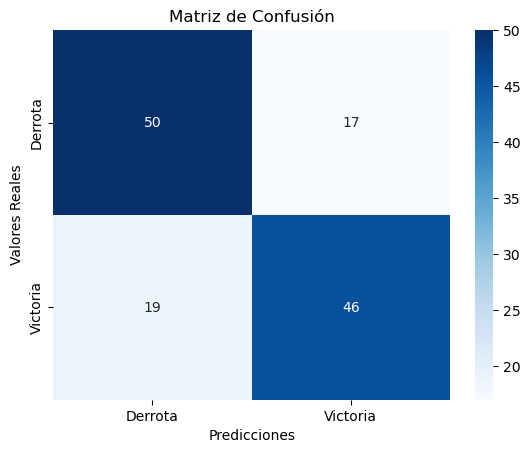


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.72      0.75      0.74        67
           1       0.73      0.71      0.72        65

    accuracy                           0.73       132
   macro avg       0.73      0.73      0.73       132
weighted avg       0.73      0.73      0.73       132



In [37]:
# Predecir y evaluar
y_pred_xgb = best_xgb_random.predict(X_test_scaled)

# Crear un heatmap de la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Derrota', 'Victoria'], yticklabels=['Derrota', 'Victoria'])
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_xgb))

**Observaciones** 
- Este es el mejor modelo, tiene 17 falsos positivos y 19 falsos positivos. Este modelo tiene el mejor rendimiento con un 0.73 de accuracy, un poco mejor que el Random forest (0.71 accuracy) y regresión logística (0.72 accuracy)
- En regresión logística aún tiene mejor detección en victorias y derrotas, el modelo XGB aún no logra discernir del todo bien las clases (f1-score de las derrotas es de 0.74 y de las victorias un 0.72), es un poco pesimista pensando que perderé cuando en realidad gané.

## Curva Roc-AUC con XGB con hiperparámetros

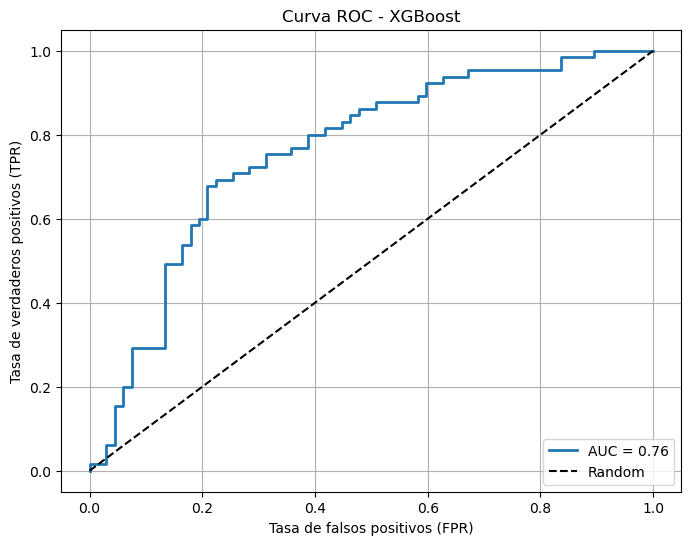

In [38]:
# Obtener probabilidades de la clase positiva (1 = Victoria)
y_probs_xgb = best_xgb_random.predict_proba(X_test_scaled)[:, 1]  # tomar solo la columna de clase positiva

# Calcular ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs_xgb)
auc = roc_auc_score(y_test, y_probs_xgb)

# Graficar curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', linewidth=2)
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Observaciones** 
- El valor AUC es de 0.76 por lo que el modelo detecta bien entre verdaderos positivos y falsos positivos, un poco mejor que la regresión logística (auc = 0.75). Es más, las probabilidades que asigna son altas y al pasar por un umbral mínimo del 50% de probabilidad de acertar, el accuracy no baja mucho.

### Importancia de variables XGB con ajuste de hiperparámetros

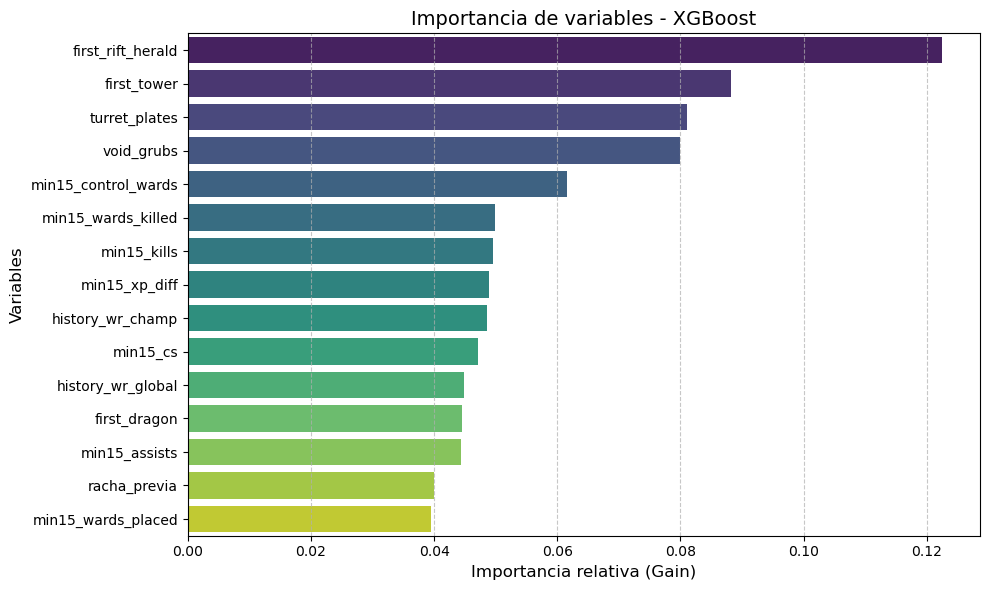

              Variable  Importancia
0    first_rift_herald     0.122543
1          first_tower     0.088155
2        turret_plates     0.081015
3           void_grubs     0.079904
4  min15_control_wards     0.061590
5   min15_wards_killed     0.049906
6          min15_kills     0.049591
7        min15_xp_diff     0.048862
8     history_wr_champ     0.048600
9             min15_cs     0.047191


In [39]:
# Extraer las importancias del mejor modelo
# XGBoost calcula automáticamente la importancia basada en la "Ganancia" (cuánto mejora el modelo al usar esta variable)
importancias = best_xgb_random.feature_importances_

# Obtener los nombres de las columnas (asegúrate de usar tu X_train o X_test que sea DataFrame)
nombres_variables = X_train_scaled.columns

# Crear un DataFrame para ordenar los datos
df_importancia = pd.DataFrame({
    'Variable': nombres_variables,
    'Importancia': importancias
})

# Ordenamos de mayor a menor importancia
df_importancia = df_importancia.sort_values('Importancia', ascending=False).reset_index(drop=True)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_importancia.head(15),
    x='Importancia', 
    y='Variable', 
    palette='viridis'
)

plt.title('Importancia de variables - XGBoost', fontsize=14)
plt.xlabel('Importancia relativa (Gain)', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Mostrar los valores numéricos
print(df_importancia.head(10))

**Observaciones** 

A diferencia del Random Forest, el XGB logró aprender patrones más especificos, no solo detectó los datos duros como random forest, sino que aprendió de cada iteración para obtener más patrones, no solo los que random forest aprendio.

- Las variables que inciden más en la prediccón de victoria o derrota en cada registro según el mejor modelo obtenido (XGB) son:
  
  - **first_rift_herald (0.12):** Asesinar el Heraldo es, al igual que en regresión, es definitivamente la variables más predictora. A pesar de haber perdido importancia en otros modelos, aún se mantiene en el top 1 de las variables predictoras.
    
  - **first_tower(0.08):** A diferencia del RF, la primera torre se considera la segunda variables más relevante.
    
  - **turret plates (0.8):** Por otro lado, las placas destruidas subió en el top. Tiene sentido dado que es oro que puede generar snowball rapidamente.
    
  - **void_grubs (0.8):** Por último, igual que como detectó parcialmente el RF, asesinar voids contribuye está en el top 5 en predicción.
 
Además, variables como control wards utilizados al minuto 15 y wards asesinado aparecen dentro del top 5, dando registro que la visión en el mapa es relevante entre un 0.06 y un 0.05 para la predicción. 

# Conclusión

### Resumen Comparativo de Modelos

| Modelo | F1 Score 0 (Derrota) | F1 Score 1 (Victoria) | Accuracy General | ROC-AUC | FN (Falsos Neg.) | FP (Falsos Pos.) | Features Importance Principales |
| :--- | :---: | :---: | :---: | :---: | :---: | :---: | :--- |
| **Reg. Logística** | 0.72 | 0.72 | 0.72 | 0.75 | 18 | 19 | First Herald, First Tower, Void Grubs (+) / Role Top, Jungle (-) |
| **SVM** | 0.71 | 0.68 | 0.70 | 0.75 | 22 | 18 | First Herald, Turret Plates, First Tower |
| **DT (Decision Tree)**| 0.68 | 0.56 | 0.63 | 0.68 | 34 | 15 | First Herald, Void Grubs, Turret Plates |
| **RF (Random Forest)**| 0.73 | 0.69 | 0.71 | 0.71 | 22 | 16 | First Tower, First Herald, Void Grubs, XP Diff min 15 |
| **MLP (Red Neuronal)**| 0.63 | 0.62 | 0.62 | 0.71 | 25 | 25 | Racha Previa, Primera Torre, Void Grubs |
| **XGB (XGBoost)** | **0.74** | **0.72** | **0.73** | **0.76** | **19** | **17** | First Herald, First Tower, Turret Plates, Void Grubs |

Sin lugar a dudas, el mejor modelo es el XGB con ajuste de hiper parámtros. Es el modelo que logra detectar mejor las victorias y derrotas con un accuracy del 0.73 y un AUC del 0.76 (identifica entre derrotas y victorias con mayor precisión). XGB logró mantener estable los falsos negativos y falsos positivos (aún es un modelo un poco pesimista pero redujo su optimismo respecto a la regresión logística) y logró definir mejor las variables que más contribuyen en la predicción.

**Análisis de variables con mayor contribución**

- **First Herald:** Asesinar el Heraldo esm definitivamente, la variables más predictora. A pesar de haber perdido importancia en otros modelos, en general asegura un rendimiento tal durante los primeros 15 minutos de juego que permite decidir con mayor precisión las victorias y derrotas. Esto implica que a pesar de que el heraldo pueda fallar (usarlo mal, fallar al tirar torre, etc) es un generador de brecha entre los equipos.

- **First Tower:** En el análisis de correlaciones el heraldo tiene una correlación moderada con tirar la primera torre (0.29) y por si mismas tienen incidencia en la victoria. Esto lo confirma XGB, ambas variables son las más predictoras lo que nos indica claramente que el obteniendo el heraldo y primera torre, la posibilidad de ganar aumenta. Ya sea que el heraldo se obtenga a partir de un mejor control de mapa por haber tirado primera torre o que el heraldo logró tirar una primera torre, en ambos casos logra generar un snowball importante en el equipo. 

- **Turrets plates:** Las placas destruidas también aparecieron como correlacion moderada en las correlaciones. A diferencia de las dos primeras variables que geenra oro global, las placas generan snowball individual. Esto genera un poder de predicción importante pero menor, dado que el efecto es más individual que global

- **Void grabs:** Como ultima variables en torno a los objetivos, la obtención de los voids grabs sirve levemente para obtener las placas de torre y con un poco más de fuerza, obtener la primera torre. Sin embargo, la correlación más fuerte con tirar la primera torre, sigue siendo hacer el heraldo por lo que, asesinar voids, es de utilidad, pero el heraldo casi dobla a esta variable en importancia.

- **min15_control_wards, min15_wards_killed:** Por otro lado, gana relevancia el control de visión en el mapa. Es mucho menos predictor, pero no deja de ser moderadamente importante para el modelo. Tener visión constante con centinelas de control y destruir los centinelas enemigos son las métricas más relevantes para mi victorias en relación al control de visión en el mapa.

- **min15_kills, min15_xp_diff, history_wr_champ, min15_cs:** Por último, el modelo considera variables de micro game, las kills que obtuve, la xp, mi win rate con el campeón que uso y el farmeo. Todas estas variables son de juego individual, son levemente relevantes a comparación con las decisiones de macro game que las superan con más del doble de importancia.

En definitiva, las variables predictoras más relevantes están en torno a objetivos importantes del early game: Heraldo y primera torre. Las variables de voids y placas ayudan de alguna manera a lograr estos objetivos principales, ya sea teniendo oro individual o contribuyendo poco a poco a tirar la primera torre. Por otro lado, la visión del mapa y el rendimiento individual no dejan de ser importantes, con menor impacto, pero con incidencia en la predicción. En resumen, para ganar tus partidas y generar snowball antes del minuto 15, enfócate en el heraldo, la primera torre y asesinar los voids. Asimismo, controla el mapa con wards de control y cuida tu KDA pero no te preocupes si vas mal, no es lo más relevante tener 20 asesinatos, sino obtener oro global destruyendo objetivos importantes que contribuyen a todo el equipo.